# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Import data

In [2]:
df = pd.read_csv('../datasets/breast-cancer-wisconsin.txt', sep=",")
df.sample(5)

,sample_num,clump_thick,cell_size,cell_shape,marg_adhesion,epith_cell_size,bare_nuclei,bland_chromatin,norm_nuclei,mitoses,class
211,1219859,8,10,8,8,4,8,7,7,1,4
367,160296,5,8,8,10,5,10,8,10,3,4
182,1204898,6,1,1,1,2,1,3,1,1,2
604,188336,5,3,2,8,5,10,8,1,2,4
58,1113483,5,2,3,1,6,10,5,1,1,4


# Explore data

In [3]:
df.shape

(699, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
sample_num         699 non-null int64
clump_thick        699 non-null int64
cell_size          699 non-null int64
cell_shape         699 non-null int64
marg_adhesion      699 non-null int64
epith_cell_size    699 non-null int64
bare_nuclei        699 non-null object
bland_chromatin    699 non-null int64
norm_nuclei        699 non-null int64
mitoses            699 non-null int64
class              699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [5]:
df.describe()

,sample_num,clump_thick,cell_size,cell_shape,marg_adhesion,epith_cell_size,bland_chromatin,norm_nuclei,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## Check missing values

In [6]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())

False
0


## Make columns same type
- bare_nuclei has a '?' as a value, which causes entire column to become non-numeric

In [7]:
df['bare_nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [8]:
# find all values in which are not ints
type(df[df['bare_nuclei'].apply(lambda x: not isinstance(x, int))]['bare_nuclei'][0])

str

In [9]:
# change all '?' to -1 to be converted to int
df['bare_nuclei'] = df['bare_nuclei'].replace('?', '-1')

In [10]:
# change all to ints
df['bare_nuclei'] = df['bare_nuclei'].astype(int)

In [11]:
# replace -1 as NaN
df['bare_nuclei'] = df['bare_nuclei'].replace(-1, np.nan)
df[df['bare_nuclei'].apply(lambda x: x == -1)]['bare_nuclei']

Series([], Name: bare_nuclei, dtype: float64)

In [12]:
# will fill these NaNs with imputer
print(df.isnull().sum().sum())

16


In [13]:
df.describe()

,sample_num,clump_thick,cell_size,cell_shape,marg_adhesion,epith_cell_size,bare_nuclei,bland_chromatin,norm_nuclei,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [17]:
samples, _ = df.shape
print("number of sample_num: ", df['sample_num'].nunique(), " / ", samples)

number of sample_num:  645  /  699


In [18]:
# drop sample_num column as there are many unique values
df.drop(columns='sample_num', inplace=True)
df.head()

,clump_thick,cell_size,cell_shape,marg_adhesion,epith_cell_size,bare_nuclei,bland_chromatin,norm_nuclei,mitoses,class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ef467c290>,
      dtype=object)

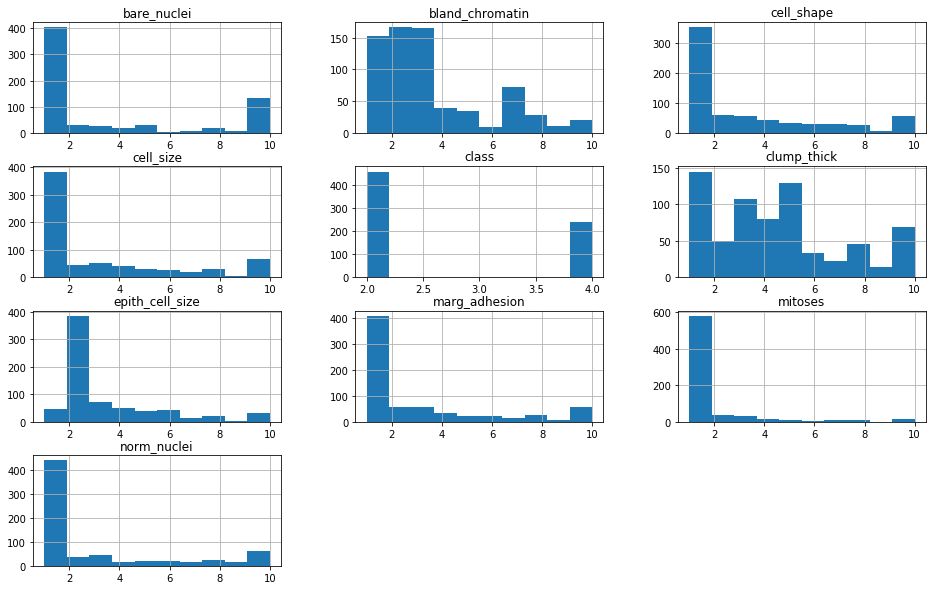

In [19]:
df.hist(figsize=(16,10))

# Machine Learning

## Define target

In [20]:
target = df['class']
df.drop(columns='class', inplace=True)
print(df.columns.values)
print(target)

['clump_thick' 'cell_size' 'cell_shape' 'marg_adhesion' 'epith_cell_size'
 'bare_nuclei' 'bland_chromatin' 'norm_nuclei' 'mitoses']
0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: class, Length: 699, dtype: int64


## Define train and test splits

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df, target, test_size=0.15, stratify=target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(594, 9)
(105, 9)
(594,)
(105,)


## Define transforms

In [22]:
imputer = SimpleImputer(strategy='median', add_indicator=True)
scaler = RobustScaler()

## Define estimator

In [23]:
lr = LogisticRegression(solver='liblinear')

## Build pipeline

In [24]:
pipeline = Pipeline(steps = [('imputer', imputer),
                             ('scaler', scaler),
                             ('Model', lr)])

## Define hyperparameter search space

In [25]:
param_grid = {"Model__C": [.01, .05, .1, .5, 1, 5, 10],
              "Model__penalty":['l1', 'l2']}

## Define grid

In [26]:
grid = GridSearchCV(pipeline, param_grid, cv=5)

## Fit model

In [27]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=True,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
               

## Best hyperparameters

In [28]:
grid.best_params_

{'Model__C': 0.01, 'Model__penalty': 'l2'}

## Make predictions

In [29]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

# Metrics

### Accuracy

In [30]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9663299663299664
0.9904761904761905


### F1 score 

In [31]:
print(f1_score(y_train, y_train_pred, average='micro'))
print(f1_score(y_test, y_test_pred, average='micro'))

0.9663299663299664
0.9904761904761905


### Confusion matrix

In [32]:
pd.crosstab(y_test, y_test_pred, 
            rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,2,4
Actual Species,,
2,68,1
4,0,36
